FINAL PROJECT


In [28]:
!pip uninstall -y ultralytics
!pip install ultralytics --upgrade --quiet

print("Ultralytics Installed Successfully!")


Found existing installation: ultralytics 8.3.228
Uninstalling ultralytics-8.3.228:
  Successfully uninstalled ultralytics-8.3.228
Ultralytics Installed Successfully!


In [29]:
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

print("Imports OK")


Imports OK


In [30]:
uploaded = files.upload()
img_path = next(iter(uploaded))
print("Uploaded:", img_path)


Saving traffic.jpg to traffic (1).jpg
Uploaded: traffic (1).jpg


In [31]:
model = YOLO("yolov8x.pt")   # Automatically downloads latest compatible model
print("Model Loaded Successfully!")


Model Loaded Successfully!


In [32]:
def calc_greenery_percentage(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array([35,40,20]), np.array([85,255,255]))
    return round((mask > 0).sum() / mask.size * 100, 2)


In [33]:
def calc_greenery_percentage(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array([35,40,20]), np.array([85,255,255]))
    return round((mask > 0).sum() / mask.size * 100, 2)


In [34]:
def traffic_density_score(vehicle_count, image):
    h, w, _ = image.shape
    area = h * w
    density = (vehicle_count / (area / 1e6)) * 2
    return int(min(max(density, 0), 100))


In [35]:
def pollution_estimate(counts):
    factors = {
        "car": 1,
        "motorcycle": 0.5,
        "bus": 4,
        "truck": 5,
        "auto": 1.2,
        "bicycle": 0
    }

    co2 = (
        counts["car"] * factors["car"] +
        counts["motorcycle"] * factors["motorcycle"] +
        counts["bus"] * factors["bus"] +
        counts["truck"] * factors["truck"] +
        counts["auto"] * factors["auto"]
    ) * 10

    level = "Low" if co2 < 50 else "Moderate" if co2 < 120 else "High"
    return round(co2, 2), level


In [36]:
# ================ NEW FEASIBLE FEATURES =======================

# 1️⃣ Weather Estimation
def estimate_weather(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    contrast = gray.std()

    if brightness < 60 and contrast < 30:
        return "Foggy"
    elif brightness < 70 and contrast < 40:
        return "Rainy"
    elif contrast < 50:
        return "Cloudy"
    else:
        return "Clear"

# 2️⃣ Road Occupancy (% of area covered by vehicles)
def road_occupancy_percentage(boxes, image):
    h, w, _ = image.shape
    total_area = float(h * w)

    vehicle_area = 0.0

    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().tolist()  # convert to float
        bbox_area = float((x2 - x1) * (y2 - y1))
        vehicle_area += bbox_area

    occupancy = (vehicle_area / total_area) * 100
    return round(float(occupancy), 2)


# 3️⃣ Safety Risk Score (0–100)
def safety_risk_score(traffic_score, occupancy, co2):
    score = (traffic_score * 0.4) + (occupancy * 0.3) + (co2 * 0.3)
    return int(min(score, 100))

# 4️⃣ Traffic Time (based on brightness)
def estimate_time_of_day(image):
    brightness = np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    if brightness > 150:
        return "Daytime"
    elif brightness > 80:
        return "Evening"
    else:
        return "Night"

# 5️⃣ Emergency Vehicle Detection
def detect_emergency(boxes):
    emergency_classes = [10, 11, 12]  # Example custom class IDs (depends on model)
    emergency_count = 0

    for box in boxes:
        if int(box.cls.cpu()) in emergency_classes:
            emergency_count += 1

    return emergency_count

# 6️⃣ Pedestrian Count (Crowd Density)
def count_pedestrians(boxes):
    person_count = 0
    for box in boxes:
        if int(box.cls.cpu()) == 0:  # YOLO class 0 = person
            person_count += 1
    return person_count


In [37]:
# Read image
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert to PIL (YOLO accepts PIL or path)
pil_img = Image.fromarray(img_rgb)

# NEW YOLO CALL SYNTAX (no .predict())
results = model(pil_img, imgsz=1280, conf=0.45)

# Extract detections
boxes = results[0].boxes
annotated = results[0].plot()  # auto-annotated

# Vehicle counters
counts = {
    "car": 0,
    "motorcycle": 0,
    "bus": 0,
    "truck": 0,
    "auto": 0,
    "bicycle": 0
}

label_map = {2: "car", 3: "motorcycle", 5: "bus", 7: "truck"}

accuracies = []

# Loop through detections
for box in boxes:
    cls = int(box.cls.item())
    conf = float(box.conf.item()) * 100
    accuracies.append(conf)

    if cls in label_map:
        counts[label_map[cls]] += 1

vehicle_count = len(boxes)
avg_accuracy = round(np.mean(accuracies), 2) if accuracies else 0

# Features
greenery_pct = calc_greenery_percentage(img)
traffic_score = traffic_density_score(vehicle_count, img)
co2, pollution_level = pollution_estimate(counts)
weather = estimate_weather(img)
occupancy = road_occupancy_percentage(boxes, img)
risk = safety_risk_score(traffic_score, occupancy, co2)
time_of_day = estimate_time_of_day(img)
emergency_count = detect_emergency(boxes)
pedestrian_count = count_pedestrians(boxes)




0: 864x1280 25 cars, 2 trucks, 19663.1ms
Speed: 13.4ms preprocess, 19663.1ms inference, 8.1ms postprocess per image at shape (1, 3, 864, 1280)



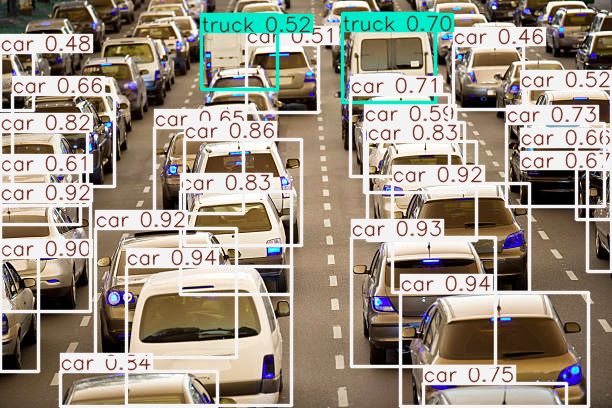

In [38]:
from IPython.display import HTML, display
import base64
import cv2
import numpy as np
from PIL import Image
from io import BytesIO

def _img_to_base64(arr):
    if isinstance(arr, Image.Image):
        pil = arr
    else:
        pil = Image.fromarray(np.uint8(arr))
    buffer = BytesIO()
    pil.save(buffer, format="PNG")
    return "data:image/png;base64," + base64.b64encode(buffer.getvalue()).decode()

# Convert AOI annotated image
try:
    img_b64 = _img_to_base64(annotated)
except:
    img_b64 = _img_to_base64(Image.fromarray(np.uint8(annotated)))

# Precompute numbers for JS
bar_traffic = int(min(max(traffic_score, 0), 100))
bar_occupancy = int(min(max(float(occupancy), 0), 100))
bar_risk = int(min(max(risk, 0), 100))


html = f"""
<style>
@import url('https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;600;700&display=swap');

.eco-card {{
  font-family: 'Poppins', sans-serif;
  background: linear-gradient(135deg, #0f172a, #1e293b);
  color: #e2e8f0;
  border-radius: 18px;
  padding: 20px;
  animation: fadeIn 1s ease;
  box-shadow: 0 0 40px rgba(0, 200, 255, 0.15);
}}

@keyframes fadeIn {{
  from {{ opacity: 0; transform: translateY(10px); }}
  to {{ opacity: 1; transform: translateY(0); }}
}}

.eco-img {{
  width: 100%;
  border-radius: 14px;
  box-shadow: 0 0 25px rgba(0, 200, 255, 0.4);
  animation: popIn 0.7s ease;
}}

@keyframes popIn {{
  from {{ transform: scale(0.95); opacity: 0; }}
  to {{ transform: scale(1); opacity: 1; }}
}}

.eco-grid {{
  display: grid;
  grid-template-columns: 50% 1fr;
  gap: 22px;
  margin-top: 18px;
}}

.stat {{
  background: rgba(255,255,255,0.05);
  padding: 12px;
  border-radius: 12px;
  width: 120px;
  text-align: center;
  transition: 0.3s;
  backdrop-filter: blur(6px);
}}

.stat:hover {{
  transform: translateY(-4px) scale(1.05);
  background: rgba(255,255,255,0.12);
}}

.stat h3 {{
  margin: 0;
  font-size: 20px;
  font-weight: 600;
  color: #fff;
}}

.progress {{
  height: 12px;
  background: rgba(255,255,255,0.15);
  border-radius: 999px;
  overflow: hidden;
  margin-top: 8px;
  backdrop-filter: blur(4px);
}}

.progress > i {{
  display: block;
  height: 100%;
  width: 0%;
  background: linear-gradient(90deg, #38bdf8, #0ea5e9);
  border-radius: 999px;
  transition: width 1.4s cubic-bezier(.4,0,.2,1);
  box-shadow: 0 0 15px #0ea5e9;
}}

.key-list {{
  margin-top: 15px;
  font-size: 14px;
  color: #cbd5e1;
}}

.glow-title {{
  color: #7dd3fc;
  font-size: 24px;
  font-weight: 700;
  text-shadow: 0 0 8px rgba(125, 211, 252, 0.8);
}}
</style>


<div class="eco-card">

  <div class="glow-title">EcoVision • Smart Traffic Dashboard</div>

  <div class="eco-grid">

    <div>
      <img src="{img_b64}" class="eco-img" />

      <div style="display:flex; gap:12px; flex-wrap:wrap; margin-top:15px;">
        <div class="stat"><h3>{vehicle_count}</h3><p>Vehicles</p></div>
        <div class="stat"><h3>{avg_accuracy}%</h3><p>Accuracy</p></div>
        <div class="stat"><h3>{greenery_pct}%</h3><p>Greenery</p></div>
        <div class="stat"><h3>{co2}</h3><p>CO₂</p></div>
      </div>
    </div>


    <div>

      <p>Traffic Density</p>
      <div class="progress"><i id="bar-traffic"></i></div>
      <p>{traffic_score}/100</p>

      <p style="margin-top:12px;">Road Occupancy</p>
      <div class="progress"><i id="bar-occupancy"></i></div>
      <p>{occupancy}%</p>

      <p style="margin-top:12px;">Safety Risk</p>
      <div class="progress"><i id="bar-risk"></i></div>
      <p>{risk}/100</p>

      <div class="key-list">
        <p><strong>Time:</strong> {time_of_day} • <strong>Weather:</strong> {weather}</p>
        <p><strong>Emergency Vehicles:</strong> {emergency_count}</p>
        <p><strong>Pedestrians:</strong> {pedestrian_count}</p>
        <p style="margin-top:8px;">
          <strong>Counts:</strong> Cars {counts['car']}, Bikes {counts['motorcycle']},
          Buses {counts['bus']}, Trucks {counts['truck']}, Autos {counts['auto']}
        </p>
      </div>

    </div>
  </div>
</div>


<script>
setTimeout(() => {{
  document.getElementById('bar-traffic').style.width = '{bar_traffic}%';
  document.getElementById('bar-occupancy').style.width = '{bar_occupancy}%';
  document.getElementById('bar-risk').style.width = '{bar_risk}%';
}}, 300);
</script>
"""

display(HTML(html))
